
# Plot Metrics from scheduler sweeps

This notebook scans folders such as `results/easy_balanced_run/300`, `results/easy_balanced_run/600`, …,
reads their `metrics.csv` (columns: `total_waiting_time,total_energy_waste`), and produces **two bar charts**:

1. **Energy Waste vs Timeout** — y = `total_energy_waste`, x = timeout value (300, 600, …).
2. **Waiting Time vs Timeout** — y = `total_waiting_time`, x = timeout value (300, 600, …).

The figures are also saved to `results/plots/`.


In [13]:

import os
import re
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Inline plots
%matplotlib inline


In [14]:

# Change this if needed
results_dir = Path('results/easy_adaptive_run')    # directory containing timeout folders
output_dir  = results_dir / 'plots'
output_dir.mkdir(parents=True, exist_ok=True)
print('Results dir:', results_dir.resolve())
print('Output dir :', output_dir.resolve())


Results dir: /home/dzikran/UGM/arsitektur-dan-infrastruktur-berkinerja-tinggi/SPARS-AIBT-2025/results/easy_adaptive_run
Output dir : /home/dzikran/UGM/arsitektur-dan-infrastruktur-berkinerja-tinggi/SPARS-AIBT-2025/results/easy_adaptive_run/plots


In [15]:

def collect_metrics(results_dir: Path):
    import pandas as pd, os
    rows = []
    for entry in results_dir.iterdir():
        if not entry.is_dir():
            continue
        try:
            k = int(entry.name)
        except ValueError:
            continue
        csv_path = entry / 'metrics.csv'
        if not csv_path.is_file():
            continue
        try:
            df = pd.read_csv(csv_path)
        except Exception as e:
            print(f"[WARN] Failed to read {csv_path}: {e}")
            continue
        cols = [c.lower().strip() for c in df.columns.tolist()]
        if 'total_waiting_time' in cols and 'total_energy_waste' in cols:
            tw = float(df['total_waiting_time'].iloc[0])
            te = float(df['total_energy_waste'].iloc[0])
        else:
            try:
                tw = float(df.iloc[0, 0])
                te = float(df.iloc[0, 1])
            except Exception as e:
                print(f"[WARN] Bad format in {csv_path}: {e}")
                continue
        rows.append((k, te, tw))
    rows.sort(key=lambda x: x[0])
    return rows

def plot_bars(xs, ys, xlabel, ylabel, title, out_path):
    import matplotlib.pyplot as plt
    import numpy as np

    # Map x labels to dense positions so bars are wider visually
    idx = np.arange(len(xs))
    fig, ax = plt.subplots()
    bars = ax.bar(idx, ys, width=0.9)  # wider bars

    # X ticks as the folder numbers
    ax.set_xticks(idx, [str(x) for x in xs])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    # Choose label format: integers -> %d, else -> %.2f
    if all(float(y).is_integer() for y in ys):
        fmt = '%d'
    else:
        fmt = '%.2f'

    # Add value labels above bars
    for rect, y in zip(bars, ys):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2.0, height,
                fmt % y,
                ha='center', va='bottom', fontsize=8, rotation=0)

    fig.tight_layout()
    fig.savefig(out_path, dpi=150)
    plt.show()


,timeout,total_energy_waste,total_waiting_time
0,300,40793233.0,56.590
1,600,50471781.0,31.540
2,900,54524056.0,26.220
3,1200,54777771.0,20.655
4,1500,58179304.0,15.175
5,1800,64566070.0,11.580
6,2100,71418364.0,9.380
7,2400,73578961.0,7.060
8,2700,74559257.0,7.060
9,3000,75536657.0,7.060


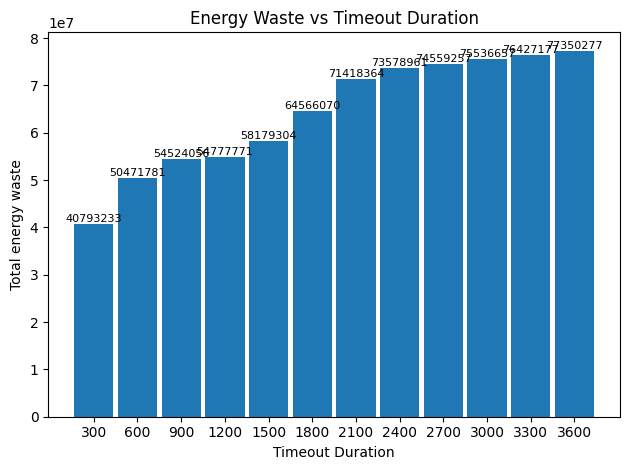

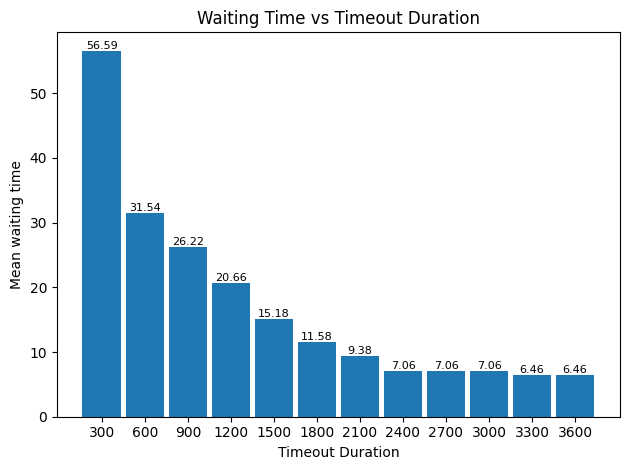

Saved: results/easy_adaptive_run/plots/summary.csv
Saved: results/easy_adaptive_run/plots/energy_waste_bar.png
Saved: results/easy_adaptive_run/plots/waiting_time_bar.png


In [16]:

rows = collect_metrics(results_dir)
if not rows:
    raise SystemExit(f"No metrics found under {results_dir}/*/metrics.csv")

xs  = [r[0] for r in rows]
tew = [r[1] for r in rows]  # total_energy_waste
twt = [r[2] for r in rows]  # total_waiting_time
twt = (np.array(twt) / 200).tolist()

# Save a summary table (optional)
summary = pd.DataFrame({'timeout': xs, 'total_energy_waste': tew, 'total_waiting_time': twt})
summary_path = output_dir / 'summary.csv'
summary.to_csv(summary_path, index=False)
display(summary)

# Plot 1: Energy waste bars
plot_bars(xs, tew, 'Timeout Duration', 'Total energy waste',
          'Energy Waste vs Timeout Duration', output_dir / 'energy_waste_bar.png')

# Plot 2: Waiting time bars
plot_bars(xs, twt, 'Timeout Duration', 'Mean waiting time',
          'Waiting Time vs Timeout Duration', output_dir / 'waiting_time_bar.png')

print('Saved:', summary_path)
print('Saved:', output_dir / 'energy_waste_bar.png')
print('Saved:', output_dir / 'waiting_time_bar.png')
